In [1]:
!rm -r maze_dataset

In [2]:
import os
import glob
import random
import numpy as np
import albumentations as A
import yaml
from tqdm import tqdm
import cv2
import numpy as np
import glob
import random
import uuid
import matplotlib.pyplot as plt

BASE_IMG_DIR = "maze_dataset_base/images"
BASE_LABEL_DIR = "maze_dataset_base/labels"
AUG_YAML = "maze_dataset/maze_dataset.yaml"
AUG_IMG_DIR = "maze_dataset/images"
AUG_LABEL_DIR = "maze_dataset/labels"

SPLITS = ["train", "val", "test"]
SPLIT_RATIOS = [0.7, 0.15, 0.15]
NUM_IMAGES = 50

CANVAS_SIZE = 2048
CROP_SIZE = 1024

In [3]:
for split in SPLITS:
    os.makedirs(os.path.join(AUG_IMG_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(AUG_LABEL_DIR, split), exist_ok=True)

data_yaml = {
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {
        0: 'maze',
        1: 'entrance'
    }
}

with open(AUG_YAML, 'w') as f:
    yaml.dump(data_yaml, f)

def bw_noise(image, intensity):
    h, w = image.shape[:2]
    num_pixels = int(h * w * intensity)
    ys = np.random.randint(0, h, size=num_pixels)
    xs = np.random.randint(0, w, size=num_pixels)
    colors = np.random.choice([0, 255], size=num_pixels)
    noisy_img = image.copy()
    if image.ndim == 3:
        noisy_img[ys, xs] = np.stack([colors]*3, axis=-1)
    else:
        noisy_img[ys, xs] = colors
    return noisy_img

class BWNoise(A.ImageOnlyTransform):
    def apply(self, img, **params):
        intensity = np.random.uniform(0, 0.02)
        return bw_noise(img, intensity=intensity)

# Augmentation
transform = A.Compose([
    A.Resize(height=CANVAS_SIZE, width=CANVAS_SIZE, p=1.0),
    A.Affine(
        translate_percent={"x": 0.01, "y": 0.01},
        scale=(0.85, 1.0),
        rotate=(-45, 45),
        p=0.8
    ),
    BWNoise(p=1.0),
    A.CenterCrop(height=CROP_SIZE, width=CROP_SIZE, p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

def load_image_on_canvas(img_path, canvas_size=CANVAS_SIZE):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    start_y, start_x = (canvas_size - h)//2, (canvas_size - w)//2
    canvas[start_y:start_y+h, start_x:start_x+w] = img
    return canvas, (w, h), (start_x, start_y)

def load_yolo_labels(label_path, img_size, offset):
    w, h = img_size
    start_x, start_y = offset
    bboxes = []
    labels = []
    with open(label_path) as f:
        for line in f:
            cls, x_c, y_c, bw, bh = map(float, line.strip().split())
            xmin = x_c * w - bw*w/2 + start_x
            ymin = y_c * h - bh*h/2 + start_y
            xmax = x_c * w + bw*w/2 + start_x
            ymax = y_c * h + bh*h/2 + start_y
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append("entrance")
    bboxes.append([start_x, start_y, start_x + w, start_y + h])
    labels.append("maze")
    return bboxes, labels

def save_yolo_labels(label_path, bboxes, labels, img_size=(1024,1024)):
    W, H = img_size
    with open(label_path, 'w') as f:
        for bbox, label in zip(bboxes, labels):
            cls = 0 if label == 'maze' else 1
            xmin, ymin, xmax, ymax = bbox
            
            x_c = ((xmin + xmax) / 2) / W
            y_c = ((ymin + ymax) / 2) / H
            bw = (xmax - xmin) / W
            bh = (ymax - ymin) / H
            
            x_c = max(0, min(1, x_c))
            y_c = max(0, min(1, y_c))
            bw = max(0, min(1, bw))
            bh = max(0, min(1, bh))
            f.write(f"{cls} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n")

image_paths = glob.glob(os.path.join(BASE_IMG_DIR, "*.png"))
label_paths = [p.replace(BASE_IMG_DIR, BASE_LABEL_DIR).replace(".png", ".txt") for p in image_paths]

total_augmented = 0
pbar = tqdm(total=NUM_IMAGES)

while total_augmented < NUM_IMAGES:
    idx = random.randint(0, len(image_paths)-1)
    img_path = image_paths[idx]
    label_path = label_paths[idx]

    if not os.path.exists(label_path):
        print(f"Missing label for {label_path}")
        continue

    canvas, img_size, offset = load_image_on_canvas(img_path)
    coords, labels = load_yolo_labels(label_path, img_size, offset)

    aug = transform(image=canvas, bboxes=coords, category_ids=labels)
    aug_img, aug_bboxes, aug_labels = aug['image'], aug['bboxes'], aug['category_ids']

    r = random.random()
    if r < SPLIT_RATIOS[0]:
        split = "train"
    elif r < SPLIT_RATIOS[0] + SPLIT_RATIOS[1]:
        split = "val"
    else:
        split = "test"

    uuid_str = str(uuid.uuid4())
    base_name = f"{uuid_str}.png"
    save_path = os.path.join(AUG_IMG_DIR, split, base_name)
    cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
    
    label_save_path = os.path.join(AUG_LABEL_DIR, split, base_name.replace(".png", ".txt"))
    save_yolo_labels(label_save_path, aug_bboxes, aug_labels)

    total_augmented += 1
    pbar.update(1)

pbar.close()


100%|██████████| 50/50 [00:02<00:00, 22.99it/s]


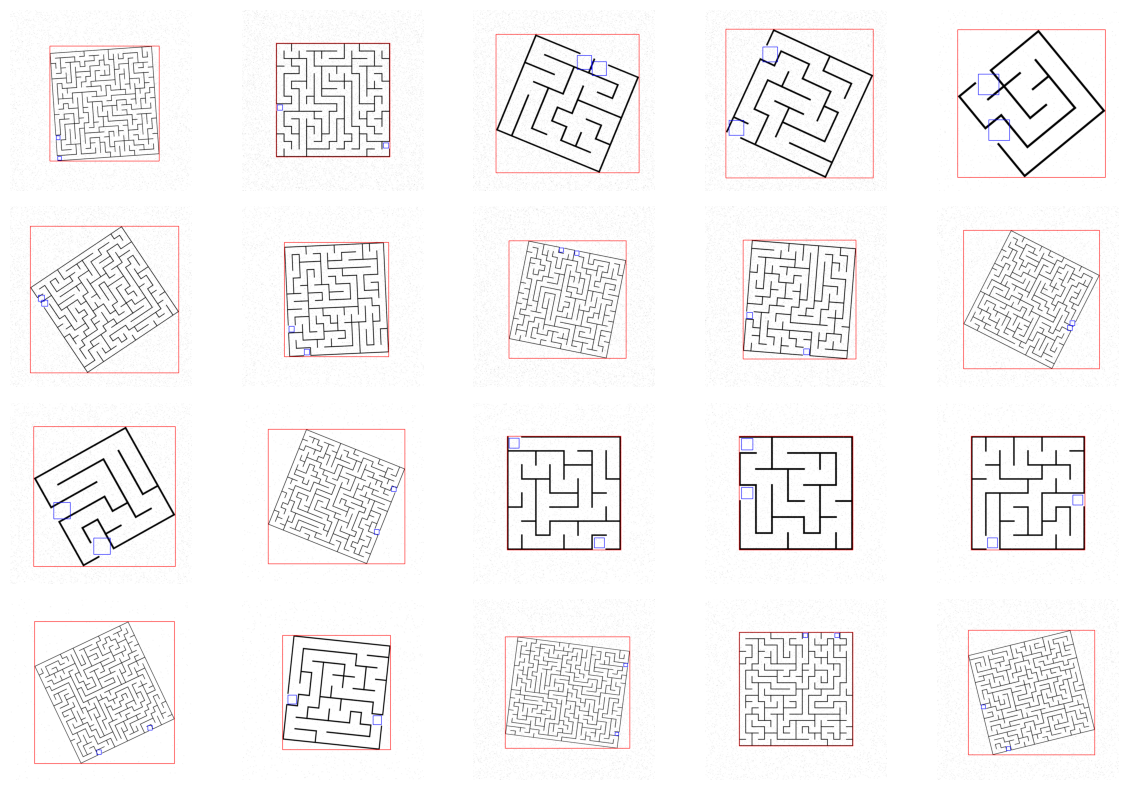

In [ ]:
all_aug_paths = sum([glob.glob(f"{AUG_IMG_DIR}/{s}/*.png") for s in SPLITS], [])
sample_paths = random.sample(all_aug_paths, 20)

def load_labels(lp):
    b, c = [], []
    for line in open(lp):
        cls, x, y, w, h = map(float, line.split())
        xmin = int((x - w/2) * CROP_SIZE); ymin = int((y - h/2) * CROP_SIZE)
        xmax = int((x + w/2) * CROP_SIZE); ymax = int((y + h/2) * CROP_SIZE)
        b.append((xmin,ymin,xmax,ymax)); c.append(int(cls))
    return b, c

fig, ax = plt.subplots(4, 5, figsize=(20, 16))
ax = ax.flatten()

for i, (a, p) in enumerate(zip(ax, sample_paths)):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    b, c = load_labels(p.replace("images","labels").replace(".png",".txt"))
    for (x1,y1,x2,y2), cls in zip(b, c):
        color = (255,0,0) if cls == 0 else (0,0,255)
        cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    a.imshow(img)
    a.axis("off")

for j in range(i+1, len(ax)):
    ax[j].axis("off")

plt.tight_layout()
plt.show()